In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 9.4MB/s 


In [4]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 160

In [0]:
from keras.layers import Layer

class BertLayer(Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

Using TensorFlow backend.


In [0]:
# Build model
def build_model(max_seq_length): 
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
    dense = Dense(256, activation='relu')(bert_output)
    pred = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
from sklearn.model_selection import train_test_split

In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [0]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
%matplotlib inline
import numpy as np
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 160

In [0]:
from keras.layers import Layer

class BertLayer(Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
# Build model
def build_model(max_seq_length): 
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
    dense = Dense(256, activation='relu')(bert_output)
    pred = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
from sklearn.model_selection import train_test_split

In [1]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

def convert_text_to_examples_test(texts):
    InputExamples = []
    for text in texts:
        InputExamples.append(InputExample(guid=None, text_a=" ".join(text), text_b=None))
    return InputExamples
def convert_examples_to_features_test(tokenizer, examples, max_seq_length=160):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids = [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
           )

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP Real or Fake/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP Real or Fake/test.csv")
original=pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP Real or Fake/NLP Original.csv")

In [0]:
# Instantiate tokenizer
tokenizer = convert_examples_to_features_test()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
train_text, test_text, train_label, test_label = train_test_split( train_df['text'], train_df['target'], test_size=0.20, random_state=42)

In [0]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels
 ) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [0]:
test_submission_examples=convert_text_to_examples_test(test_df['text'])
(test_input_ids_submisson, test_input_masks_submisson, test_segment_ids_submisson
) = convert_examples_to_features_test(tokenizer, test_submission_examples, max_seq_length=max_seq_length)

In [0]:
in_id = Input(shape=(max_seq_length,), name="input_ids")
in_mask = Input(shape=(max_seq_length,), name="input_masks")
in_segment = Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]
bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
dense = Dense(256, activation='relu')(bert_output)
pred = Dense(1, activation='sigmoid')(dense)
    
model = Model(inputs=bert_inputs, outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 160)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 160)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 160)          0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        ((None, 160), 768)   110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
history=model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=5,
    batch_size=128 )

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 113s 19ms/step - loss: 0.7187 - acc: 0.5995 - val_loss: 0.6304 - val_acc: 0.6395
Epoch 2/5
6090/6090 [==============================] - 104s 17ms/step - loss: 0.6300 - acc: 0.6443 - val_loss: 0.6057 - val_acc: 0.6763
Epoch 3/5
6090/6090 [==============================] - 104s 17ms/step - loss: 0.6216 - acc: 0.6542 - val_loss: 0.6033 - val_acc: 0.6756
Epoch 4/5
6090/6090 [==============================] - 104s 17ms/step - loss: 0.6013 - acc: 0.6862 - val_loss: 0.5864 - val_acc: 0.6940
Epoch 5/5
6090/6090 [==============================] - 104s 17ms/step - loss: 0.5854 - acc: 0.6957 - val_loss: 0.5925 - val_acc: 0.6940


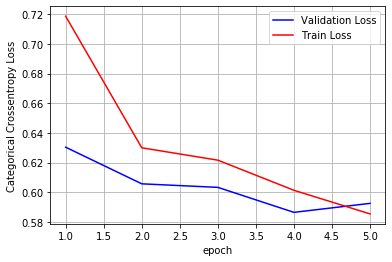

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,6))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
history=model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=5,
    batch_size=128 )

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
2176/6090 [=========>....................] - ETA: 54s - loss: 0.3994 - acc: 0.8263

KeyboardInterrupt: ignored

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,6))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
# model = build_model(max_seq_length)

# # Instantiate variables
# initialize_vars(sess)

# model.fit(
#     [train_input_ids, train_input_masks, train_segment_ids], 
#     train_labels,
#     validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
#     epochs=1,
#     batch_size=32 )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 160)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 160)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 160)          0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        ((None, 160), 768)   110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

KeyboardInterrupt: ignored

In [0]:
pred=model.predict([test_input_ids_submisson, test_input_masks_submisson, test_segment_ids_submisson])

In [0]:
f1_score(original['target'], pred.round())

0.661422484431334

In [0]:
original['target'].value_counts()

0    1861
1    1402
Name: target, dtype: int64

In [0]:
pred.to_csv("submission.csv")

AttributeError: ignored